In [1]:
# see https://docs.pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
# and https://github.com/theeluwin/pytorch-sgns/
# and https://jalammar.github.io/illustrated-word2vec/
# and https://adoni.github.io/2017/11/08/word2vec-pytorch/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, IterableDataset
from torch.utils.data import DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

from collections import Counter

import math, random

from typing import Sequence, Optional, Callable, List

from visuEmbedding import interactive_embedding_plot_2D, interactive_embedding_plot_3D, plot_similarity_heatmap, cluster_words, components_to_fig_3D

# torch.manual_seed(1)
device = 'cpu'

In [2]:
# assert True
# assert False

# DataSet (statique)

Pour entraîner notre Word2Vec, il nous faut un jeu de donné particulier. Nous voulons "reprocher" certains mots et en "éloigner" d'autre. Il faut créer des pairs de similarité et de différence. Ce sont des pairs positif et négatif. Nous pouvons "forcer" ses paires, ou, de manière non supervisé, prendre un texte et créer automatiquement les paires. 

## Statique ?

Dans une première version nous créons/chargeons toutes les paires en amont. Si nous passons toutes ces pairs à un data loader de pytorch, toutes ces pairs serons chargé en mémoire. Ce qui peut être trop gros.

## Créations automatique de pair (mots positif)

Pour créer automatiquement des pairs positif et négatifs, nous allons devoir déterminer des mots "centraux". Ces mots serons rattaché à tout les mots présent dans une certaine fenêtre de celui ci.

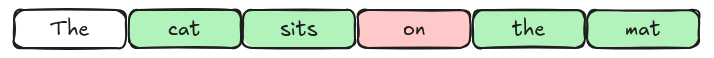

Par exemple dans cette phrase, si nous prenons "on" comme mot central, alors ["cat", "sits", "the", "mat"] serons des mots de contexte. Nous pouvons formé les pairs positifs : [("on", "cat"), ("on", "sits"), ("on", "the"), ("on", "mat")].

### Subsampling

Nous ne voulons pas forcement prendre tout les mots comme mots central. Dans la phrase d'exemple nous aurions deux fois le mots "the" comme mot central, cela induirais un biais lors de l’entraînement dans lequel les mots trop fréquents serais sur représenté. Dans l'idéal, avec la phrase d'exemple nous voudrions qu'un seul "the" soit sélectionné. Pour ce faire nous calculons la fréquence de chaque mots (The : 2; cat : 1, sits : 1; on : 1; "mat": 1) puis, nous calculons une probabilité de le sélectionné (dans l'idéal 50% pour le mot "the" et 100% pour les autres). Cette idée s'appelle le **Subsampling** et nous vient du papier original du Word2Vec : "Distributed Representations of Words and Phrases and their Compositionality". La formule utilisé pour calculer la probabilité est :

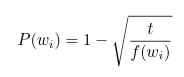 

Où f(wi) est la fréquence d’apparition du mot wi et t est un seuil qui permet de plus ou moins diminuer la probabilité des mots fréquents.

Voici une implémentation possible de la formule en python :

In [9]:
data = ["a", "b", "b", "b", "c", "c", "d","d","d"] 
freq = Counter(data) # Calcul de la fréquence des mots
print("La fréquence des mots du texte :")
print(freq)

# On prend par exemple le mots "b"
f = freq["b"] # Le nombre de fois que le mots apparaît dans le texte
print(f"le mots b apparaît {f} fois")

t = 1e-1 * len(data)# Le seuil qui permet de savoir a partir de quand on diminue la probabilité du mots d'apparaître

print(f"Le mots b a {((f / t)**0.5 + 1) * (t / f) * 100 } % avec t {t} d'être un mots central a noter que la formule peut donner un nombre > à 100 (dans se cas on borne a 100)")

t = 1e-2 * len(data)

print(f"Avec un seuil plus petit ({t}) le mots b a {((f / t)**0.5 + 1) * (t / f) * 100 } % d'être un mots central")

La fréquence des mots du texte :
Counter({'b': 3, 'd': 3, 'c': 2, 'a': 1})
le mots b apparaît 3 fois
Le mots b a 84.7722557505166 % avec t 0.9 d'être un mots central a noter que la formule peut donner un nombre > à 100 (dans se cas on borne a 100)
Avec un seuil plus petit (0.09) le mots b a 20.320508075688775 % d'être un mots central


# Mots négatifs
Pour déterminer les mots négatifs des mots centraux, on veut connaître la proportion de chaque mots dans tout le corpus. On utilise ce code :
```py
freq_list = [self.freq.get(self.decoder[i], 0) for i in range(self.vocab_size)]
unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
unigram / unigram.sum()
```

En plus d'un "simple" calcul de proportions, nous avons un atténuateur power. Si il est < 1 alors les mots plus fréquents serons atténué. Si il est > 1 alors c'est l'inverse. L'idée nous vient aussi de "Distributed Representations of Words and Phrases and their Compositionality" qui montre que pour leur jeu de données, une puissance de 3/4 est l'idéal.

Voici une implémentation possible de cette idée :


In [4]:
freq = Counter(data)
set_vocab = set(data)
power = 1

freq_list = [freq.get(i, 0) for i in set_vocab]
unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
print("Avec un power = 1 proportion réel")
print(unigram / unigram.sum())
print(set_vocab)

power = 0.1
freq_list = [freq.get(i, 0) for i in set_vocab]
unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
print("avec un power = 0.01 proportion atténué")
print(unigram / unigram.sum())
print(set_vocab)


Avec un power = 1 proportion réel
tensor([0.3333, 0.2222, 0.3333, 0.1111])
{'d', 'c', 'b', 'a'}
avec un power = 0.01 proportion atténué
tensor([0.2593, 0.2490, 0.2593, 0.2323])
{'d', 'c', 'b', 'a'}


Maintenant pour chaque mot centraux, nous pouvons prendre des mots négatif suivant la distribution calculé. A noté que des mots trop fréquent risque de se retrouver à la fois positifs et négatifs. C'est quelque chose qui ne parait pas abérant, car des mots trop fréquent ne sont pas des mots que l'on veut rapproché. Par exemple le mot "le" peut être lié a beaucoup de mot. Donc on ne veut pas le rapproché d'un mot en particulier.

In [5]:
class SGNS_store_DataSet(Dataset):
    """ 
    Dataset pour word2vec avec les négatives sampling.
    """
    def _dist_unigram(self, power:float):
        # La distribution unigram ^.75
        freq_list = [self.freq.get(self.decoder[i], 0) for i in range(self.vocab_size)]
        unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
        return unigram / unigram.sum()
    
    def _proba_words(self):
        # Calcul des probabilité de garder un mot.
        if self.subsample_thresh > 0.0:
            # probabilité de garder un mot: p = (sqrt(f_t / t) + 1) * (t / f_t)
            total_tokens = sum(self.freq.values())
            word_probs = {}
            t = self.subsample_thresh * total_tokens
            for w, c in self.freq.items():
                f = c
                prob_keep = ((f / t)**0.5 + 1) * (t / f)
                # clamp between 0 and 1
                word_probs[w] = min(1.0, prob_keep)
        else:
            word_probs = None
        return word_probs

    def _make_pairs(self):
        self.pairs = []
        for sent in self.sentences:
            # option subsampling pendant pré-construction si activé
            if self.word_probs is not None:
                filtered = [w for w in sent if random.random() < self.word_probs.get(w, 1.0)]
            else:
                filtered = sent
            ids = [self.encoder[w] for w in filtered if w in self.encoder]
            L = len(ids)
            for i, center in enumerate(ids):
                # fenêtre aléatoire entre 1 et window_size (pratique commune)
                # Évite le biais d'un apprentissage sur un contexte fixe, ajoute de la dynamique dans l'apprentissage 
                # cur_window = random.randint(1, self.context_size)
                cur_window = self.context_size
                start = max(0, i - cur_window)
                end = min(L, i + cur_window + 1)
                for j in range(start, end):
                    if j == i:
                        continue
                    context = ids[j]
                    self.pairs.append((center, context))

    def __init__(self, sentences:list[list[str]], window_size:int=2, nb_neg:int=5, power=0.75,
                 subsample_thresh:float=1e-5 , vocab_freq:None|dict|Counter=None, vocab_size_limit:None|int=None):
        """Initialise le dataset pour du Word2Vec avec des pairs négative. (Warning Méthode qui stocke en mémoire)
        
        Args:
            sentences: Liste des phrases du corpus de texte (une phrases doit être une liste de str)
            window_size: La taille de fenêtre pour créer les pairs positif.
            nb_neg: Nombre de pair négatif pour chaque mots. (K)
            subsample_thresh: Pour réduire la fréquence des mots trop fréquent (Ex : de, le, la, ...) dans le choix des mots centraux
            power: Pour réduire la fréquence des mots trop fréquent dans les négatifs
            vocab_freq: Dictionnaire ou counter (https://docs.python.org/3/library/collections.html#counter-objects) pour chaque mots indique la fréquence de se mot dans tout le corpus
            vocab_size_limit: Pour ne garder que les top-N mots par fréquence
        """
        super().__init__()
        subsample_thresh = float(subsample_thresh)
        # assert isinstance(sentences, list[list[str]]), "sentences should be a list[list[str]]"
        assert isinstance(window_size, int), "sentences should be a int"
        assert isinstance(nb_neg, int), "sentences should be a int"
        assert isinstance(subsample_thresh, float), "sentences should be a float"

        self.sentences:list[list[str]] = sentences
        self.context_size:int = window_size
        self.K:int = nb_neg
        self.power = power

        if vocab_freq is not None:
            full_freq:Counter = Counter(vocab_freq)
        else:
            all_tokens = [t for s in sentences for t in s]
            full_freq:Counter = Counter(all_tokens)

        if vocab_size_limit is not None:
            most_common = full_freq.most_common(vocab_size_limit)
            kept_words = [w for w, _ in most_common]
            # On recalcul la fréquence des mots
            self.freq = Counter({w: full_freq[w] for w in kept_words})
        else:
            self.freq = full_freq

        self.vocab = list(self.freq.keys())
        self.vocab_size:int = len(self.vocab)
        self.encoder:dict = {w:i for i,w in enumerate(self.vocab)}
        self.decoder = {i:w for w,i in self.encoder.items()}

        # Calcul de la distibution ungigram permettant de créer les pairs négatifs
        self.unigram_dist = self._dist_unigram(self.power)

        # Calcul de la probabilité de garder les mots
        self.subsample_thresh:float = subsample_thresh
        self.word_probs:dict = self._proba_words()

        # Create pairs  
        self.pairs = None
        self._make_pairs()
        assert len(self.pairs) != 0 , "Error to make positif pairs"

    def __len__(self):
        return len(self.pairs)
    
    def _sample_negatives(self, batch_size):
        """
        Échantillonne (batch_size, K) négatifs selon self.unigram_dist.
        
        Args:
            batch_size: La taille de batch [B]

        Return:
           torch.LongTensor
        """
        # torch.multinomial attend vecteur de probabilités ; on échantillonne batch_size*K et reshape
        neg = torch.multinomial(self.unigram_dist, batch_size * self.K, replacement=True)
        return neg.view(batch_size, self.K)    

    def __getitem__(self, idx):
        """Prends la pairs positif idx (idx >= 0 and idx < len(self.pairs) et les négatifs qui sont calculé avec la distribution unigram

        Args:
            idx: Index de la pairs positifs.

        Return :
            Tuple(center_id:Long, pos_id:long, negatives_ids: torch.LongTensor de taille [K])
        - center_id: long
        - pos_id: long
        - negatives: torch.LongTensor shape [K]
        """
        center, pos = self.pairs[idx]
        # neg = torch.multinomial(self.unigram_dist, self.K, replacement=True)
        neg = torch.multinomial(self.unigram_dist, self.K, replacement=True)
        return torch.tensor(center, dtype=torch.long), torch.tensor(pos, dtype=torch.long), neg

    def collate_batch(self, batch):
        """Fonction de collate pour DataLoader.
        Args:
            batch: list of tuples (center, pos, neg) où neg is tensor [K]
        Return:
            Tuple(centers:Torch.Tensor [B], pos:Torch.Tensor [B], neg:Torch.Tensor [B, K])
        """
        centers = torch.stack([item[0] for item in batch], dim=0)
        pos = torch.stack([item[1] for item in batch], dim=0)
        negs = torch.stack([item[2] for item in batch], dim=0)
        return centers, pos, negs

    def sample_batch_negatives(self, centers, K=None):
        """Méthode pour voir un échantillons de pairs négatifs sur un batch de mots centraux
        Args:
            centers: Tensor d'idx des mots centraux
        Return:
            Torch.Tensor() [B K]
        """
        B = centers.size(0)
        K = self.K if K is None else K
        return torch.multinomial(self.unigram_dist, B * K, replacement=True).view(B, K)
    
    def encode(self, words:list|str) -> list|int:
        if isinstance(words, str) : return self.encoder[words]
        ids = []
        for w in words :
            ids.append(self.encoder[w])
        return ids
    
    def decode(self, ids:list|int) -> list|int:
        if isinstance(ids, int) : return self.decoder[ids]
        words = []
        for i in ids :
            words.append(self.decoder[i])
        return words

In [6]:
# Le modèle SkipGramModel
class SkipGramModel(nn.Module):
    def __init__(self, emb_size:int, embedding_dimension:int=15, sparse:bool=False, context_dimension:int|None=None):
        """Initialisation du modèle SkipGram
        Args:
            emb_size: La taille de l'embedding, ce nombre devrais être déterminé après le process sur les data, et dépend de la taille de la fenêtre glissante.
            embedding_dimension: La taille souhaité de l'embedding. Pour notre cas d'utilisation nous préférons une taille très petit
            sparse: Bool permettant l'optimisation des calcul par pytorch si la fonction d'optimisation SGD est utilisé.
            context_dimension: Il n'est pas recommandé de mettre un entier mais de laisser a None.
        
        """
        super().__init__()
        self.emb_size:int = emb_size
        self.emb_dim:int = embedding_dimension
        # On définit pour chaque mots un embedding (soit un vecteur qui représente le mots)
        self.word_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.emb_dim, device=device)

        # Ce deuxième embedding correspond au mots utilisé dans un contexte (!= d'être utiliser comme mot centrale)
        self.con_size = embedding_dimension if context_dimension is None else context_dimension
        self.con_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.con_size, device=device)

        init_range = 0.5 / self.emb_dim
        self.word_emb.weight.data.uniform_(-init_range, init_range)
        self.con_emb.weight.data.uniform_(-init_range, init_range)

    def forward(self, centrals_words:list|torch.Tensor, pos_context:list|torch.Tensor, neg_context:list|torch.Tensor):
        """Fonction du forward pour le modèle SkipGramModel
        Args:
            centrals_words: Liste des ids des tokens des mots centraux [B]
            pos_context: Liste des ids des tokens des mots dans le contexte [B]
            neg_context: Liste des ids des tokens des mots non présent dans le contexte [B, K]
        """
        # B : batch size
        # D : dimension de l'embedding
        # K : Nombre de mots négatifs

        # Pour chaque pair positif, on récupère :
        # Le vecteur du mots centrale (les valeurs de l'embeddding pour le token)
        words_emb:torch.Tensor = self.word_emb(centrals_words) # [B, D]
        # Le vecteur du mots contexte
        context_emb:torch.Tensor = self.con_emb(pos_context) # [B, D]
        # Et les vecteurs des mots négatifs
        neg_emb:torch.Tensor = self.con_emb(neg_context) # [B, K, D]

        # Pour chaque pair on calcul le score de similarité (mots central et contexte positif)
        # positive score: log sigma(u . v_pos)
        pos_score = torch.sum(words_emb * context_emb, dim=1)
        # See https://docs.pytorch.org/docs/stable/generated/torch.nn.LogSigmoid.html#logsigmoid pour la LogSigmoid 
        pos_loss = F.logsigmoid(pos_score)

        # On calcul aussi le score de dissimilarité (mots centrals et les mots non présent dans le context)
        # negative score: sum log sigma(-u . v_neg)
        # neg_emb : [B, K, D], on veut multiplier les vecteurs pour chaque mots
        # Il faut donc ajouter une dimension à words_emb (voir https://docs.pytorch.org/docs/stable/generated/torch.bmm.html#torch-bmm)
        # words_emb.unsqueeze(2) : [B, D, 1]
        # See https://docs.pytorch.org/docs/stable/generated/torch.unsqueeze.html#torch-unsqueeze pour l'ajout de dimension
        neg_score = torch.bmm(neg_emb, words_emb.unsqueeze(-1)).squeeze(2)
        neg_loss = F.logsigmoid(-neg_score).sum(1)

        loss = -(pos_loss + neg_loss).mean()
        return loss
    
    def save_weight(self, path:str="SGNS_weights/"):
        """Sauvegarde des poids des deux embeddings (word embedding et context embedding) dans le dossier path
        Args :
            path: Le dossier dans lequel sauvegarder les poids des deux embeddings
        """
        word_weights = self.word_emb.weight.detach().cpu()
        con_weight = self.con_emb.weight.detach().cpu()
        torch.save(word_weights, path+'word_embedding.pt')
        torch.save(con_weight, path+'con_embedding.pt')

    def load_weight(self, path:str="SGNS_weights/", name_word_weights:str="word_embedding.pt", name_con_weights:str="con_embedding.pt"):
        """Charge les poids depuis un fichier de sauvegarde de pytorch
        Args :
            path: Le dossier où se trouve les deux fichiers des poids
            name_word_weights: Le nom du fichier contenant les poids du word embedding
            name_con_weights: Le nom du fichier contenant les poids du contexte embedding
        """
        word_weights = torch.load(path + name_word_weights)
        con_weight = torch.load(path + name_con_weights)

        self.word_emb:nn.Embedding = nn.Embedding.from_pretrained(word_weights)
        self.con_emb:nn.Embedding = nn.Embedding.from_pretrained(con_weight)



In [7]:
{
# class SGNS_Streaming_Dataset(Dataset):
#     """Dataset pour le SGNS fait de manière dynamique, pour éviter de devoir stoker de grand corpus.
#     À utiliser pour de grand corpus

#     100% chat GPT :
#     """

#     """
#     Dataset de type map-style mais sans pré-construction des paires.
#     Il estime un nombre total d'exemples via le nombre total de tokens et window_size.
#     __getitem__(i) génère une paire aléatoire en parcourant le corpus de façon pseudo-aléatoire.
#     Utile si on veut compatibilité DataLoader (shuffle géré par DataLoader) mais sans stocker pairs.
#     """
#     def __init__(self, sentences, word_to_idx, vocab_freq=None, window_size=5, K=5, subsample_thresh=0.0, approx_multiplier=2):
#         super().__init__()
#         self.sentences = sentences                # list[list[str]]
#         self.word_to_idx = word_to_idx
#         self.idx_to_word = {i:w for w,i in word_to_idx.items()}
#         self.vocab_size = len(self.idx_to_word)
#         self.window_size = window_size
#         self.K = K

#         # fréquences
#         if vocab_freq is None:
#             all_tokens = [t for s in sentences for t in s]
#             self.freq = Counter(all_tokens)
#         else:
#             self.freq = Counter(vocab_freq)

#         # unigram^0.75 distribution pour neg sampling
#         power = 0.75
#         freq_list = [self.freq.get(self.idx_to_word[i], 0) for i in range(self.vocab_size)]
#         unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
#         self.unigram_dist = unigram / unigram.sum()

#         # subsampling
#         self.subsample_thresh = float(subsample_thresh)
#         if self.subsample_thresh > 0.0:
#             total = sum(self.freq.values())
#             t = self.subsample_thresh * total
#             self.word_keep_prob = {}
#             for w, c in self.freq.items():
#                 f = c / total
#                 prob = ( (f / self.subsample_thresh)**0.5 + 1) * (self.subsample_thresh / f)
#                 self.word_keep_prob[w] = min(1.0, prob)
#         else:
#             self.word_keep_prob = None

#         # construire indexation "plat" des (sentence_idx, token_idx) pour accès rapide aux tokens
#         # pour gros corpus on peut éviter ceci et itérer fichiers; ici on construit une table d'offsets (faible mémoire)
#         self.sentence_lengths = [len(s) for s in self.sentences]
#         self.cum_lengths = []
#         c = 0
#         for L in self.sentence_lengths:
#             self.cum_lengths.append(c)
#             c += L
#         self.total_tokens = c

#         # approx length pour DataLoader (nombre d'exemples de paires estimé)
#         # Chaque token génère en moyenne ~2*window_size contextes (approx); multiplier pour marge
#         self.approx_len = max(1, int(self.total_tokens * min(self.window_size, 5) * approx_multiplier))

#     def __len__(self):
#         return self.approx_len

#     def _get_token_at(self, flat_idx):
#         """Retourne (sent_idx, tok_idx, token_str) pour un index plat dans [0, total_tokens)."""
#         # bsearch cum_lengths pour trouver sent
#         # simple linéar scan possible, mais on utilise bisect pour efficience
#         import bisect
#         sent_idx = bisect.bisect_right(self.cum_lengths, flat_idx) - 1
#         if sent_idx < 0:
#             sent_idx = 0
#         tok_idx = flat_idx - self.cum_lengths[sent_idx]
#         sent = self.sentences[sent_idx]
#         if tok_idx >= len(sent):
#             # cas improbable dû aux limites; normaliser
#             tok_idx = len(sent) - 1
#         return sent_idx, tok_idx, sent[tok_idx]

#     def __getitem__(self, idx):
#         """
#         Génère une paire (center, context, negatives) pseudo-aléatoire à partir d'un index.
#         - idx est utilisé pour varier la position, puis on choisit une fenêtre aléatoire autour du token.
#         """
#         # map idx -> flat token index (cycle)
#         flat_idx = idx % max(1, self.total_tokens)
#         sent_idx, tok_idx, token = self._get_token_at(flat_idx)

#         # si subsampling activé, rejeter token avec proba 1 - keep_prob et chercher un autre
#         if self.word_keep_prob is not None:
#             attempts = 0
#             while random.random() > self.word_keep_prob.get(token, 1.0):
#                 flat_idx = (flat_idx + 1) % max(1, self.total_tokens)
#                 sent_idx, tok_idx, token = self._get_token_at(flat_idx)
#                 attempts += 1
#                 if attempts > 10_000:
#                     break

#         # construire la liste des indices valides de contexte dans la phrase
#         sent = self.sentences[sent_idx]
#         L = len(sent)
#         if L <= 1:
#             # phrase triviale -> retourner token négatifs aléatoires
#             center = self.word_to_idx.get(token, None)
#             if center is None:
#                 # choisir un centre aléatoire si token OOV
#                 center = random.randrange(self.vocab_size)
#             pos = center
#         else:
#             cur_window = random.randint(1, self.window_size)
#             start = max(0, tok_idx - cur_window)
#             end = min(L, tok_idx + cur_window + 1)
#             # lister les context positions possibles et choisir un contexte aléatoire
#             context_positions = [j for j in range(start, end) if j != tok_idx]
#             if not context_positions:
#                 pos_token = token
#             else:
#                 pos_tok_idx = random.choice(context_positions)
#                 pos_token = sent[pos_tok_idx]
#             # convertir en ids (gestion OOV)
#             center = self.word_to_idx.get(token, None)
#             pos = self.word_to_idx.get(pos_token, None)
#             if center is None:
#                 center = random.randrange(self.vocab_size)
#             if pos is None:
#                 pos = random.randrange(self.vocab_size)

#         # échantillonnage négatifs (K)
#         neg = torch.multinomial(self.unigram_dist, self.K, replacement=True)

#         return torch.tensor(center, dtype=torch.long), torch.tensor(pos, dtype=torch.long), neg


# class IterableSkipGramDataset(IterableDataset):
#     """
#     Version streamable recommandée: IterableDataset qui parcourt les phrases et génère paires à la volée.
#     Idéal pour très grands corpus lus depuis disque (fichiers, lignes, gzip).
#     """
#     def __init__(self, sentences_iterable, word_to_idx, vocab_freq=None, window_size=5, K=5, subsample_thresh=0.0):
#         """
#         sentences_iterable: callable ou itérable qui renvoie un itérateur de phrases tokenisées.
#           - Peut être une fonction generator() pour redémarrer l'itération à chaque epoch,
#             ou un itérable unique (non-recommencé) si training en un seul passage.
#         """
#         super().__init__()
#         self.sentences_iterable = sentences_iterable
#         self.word_to_idx = word_to_idx
#         self.idx_to_word = {i:w for w,i in word_to_idx.items()}
#         self.vocab_size = len(self.idx_to_word)
#         self.window_size = window_size
#         self.K = K

#         # fréquences et unigram pour neg sampling (si non fournies, construire approximation légère)
#         if vocab_freq is None:
#             # si vocab_freq absent, construire à partir d'un premier passage (coûteux)
#             raise ValueError("Pour IterableSkipGramDataset, fournis vocab_freq ou un precomputed unigram distribution.")
#         self.freq = Counter(vocab_freq)
#         power = 0.75
#         freq_list = [self.freq.get(self.idx_to_word[i], 0) for i in range(self.vocab_size)]
#         unigram = torch.tensor([f**power for f in freq_list], dtype=torch.float)
#         self.unigram_dist = unigram / unigram.sum()

#         # subsampling
#         self.subsample_thresh = float(subsample_thresh)
#         if self.subsample_thresh > 0.0:
#             total = sum(self.freq.values())
#             t = self.subsample_thresh * total
#             self.word_keep_prob = {}
#             for w, c in self.freq.items():
#                 f = c / total
#                 prob = ( (f / self.subsample_thresh)**0.5 + 1) * (self.subsample_thresh / f)
#                 self.word_keep_prob[w] = min(1.0, prob)
#         else:
#             self.word_keep_prob = None

#     def get_sent_iterator(self):
#         # si sentences_iterable est callable, appelez-le pour obtenir un nouvel itérateur par epoch
#         if callable(self.sentences_iterable):
#             return self.sentences_iterable()
#         else:
#             return iter(self.sentences_iterable)

#     def __iter__(self):
#         sent_iter = self.get_sent_iterator()
#         for sent in sent_iter:
#             # sent : liste de tokens
#             # appliquer subsampling à la volée
#             if self.word_keep_prob is not None:
#                 filtered = [w for w in sent if random.random() < self.word_keep_prob.get(w, 1.0)]
#             else:
#                 filtered = sent
#             ids = [self.word_to_idx.get(w, None) for w in filtered]
#             # filtrer OOV
#             ids = [i for i in ids if i is not None]
#             L = len(ids)
#             if L <= 1:
#                 continue
#             for i, center in enumerate(ids):
#                 cur_window = random.randint(1, self.window_size)
#                 start = max(0, i - cur_window)
#                 end = min(L, i + cur_window + 1)
#                 for j in range(start, end):
#                     if j == i:
#                         continue
#                     pos = ids[j]
#                     neg = torch.multinomial(self.unigram_dist, self.K, replacement=True)
#                     yield torch.tensor(center, dtype=torch.long), torch.tensor(pos, dtype=torch.long), neg
}

{}

In [ ]:
def train_Word2Vec(modelW2V:nn.Module, dataLoader:Dataset, optimizer:optim.Optimizer, epochs:int, verbal:bool=True, log_interval = 100):
    """Fonction d’entraînement pour un modèle Word2Vec

    """
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        batches = 0
        loss_history = []
        global_step = 0
        
        modelW2V.train()

        for batch in dataLoader:
            # centers: [B], pos: [B], negs: [B, K]
            centers, pos, negs = batch
            centers = centers.to(device)
            pos = pos.to(device)
            negs = negs.to(device)

            optimizer.zero_grad()
            loss = modelW2V(centers, pos, negs)
            loss.backward()

            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss
            loss_history.append(batch_loss)
            batches += 1
            global_step += 1

            if verbal and log_interval and (global_step % log_interval == 0):
                print(f"Epoch {epoch} Step {global_step} AvgLoss {epoch_loss / batches:.6f}")

        avg_epoch_loss = epoch_loss / max(1, batches)
        if verbal : print(f"Epoch {epoch} finished. Avg loss: {avg_epoch_loss:.6f}")
    return {"loss_history": loss_history, "final_epoch_loss": avg_epoch_loss}


IndentationError: unexpected indent (1158029115.py, line 38)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import csv
import unicodedata
import string


CONTRACTION_MAP = {
    "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
    "'d": " 'd", "'s": " 's", "'m": " 'm"
}

def remove_accents(text: str) -> str:
    nk = unicodedata.normalize("NFKD", text)
    return "".join([c for c in nk if not unicodedata.combining(c)])

keep = {"'", "’"}
punct_to_remove = ''.join(ch for ch in string.punctuation if ch not in keep)

extra_punct = '“”‘’—–…«»'
punct_to_remove += ''.join(ch for ch in extra_punct if ch not in keep)
TRANSL_TABLE = str.maketrans('', '', punct_to_remove)

new_txt = []
tokens_by_sentence = []

# with open("chat_chien.txt", encoding='utf-8') as file:
#     for sentence in file:
#         # print("original sentence :", sentence.rstrip('\n'))
#         sentence = sentence.lower()
#         sentence = remove_accents(sentence)
#         for k, v in CONTRACTION_MAP.items():
#             sentence = sentence.replace(k, v)
#         sentence = sentence.translate(TRANSL_TABLE)
#         sentence = ' '.join(sentence.split())
#         # print("sentence keep : ", sentence)
#         new_txt.append(sentence + "\n")
#         tokens_by_sentence.append(word_tokenize(sentence, language="french"))

# with open("toy.txt", encoding='utf-8') as file:
#     for sentence in file:
#         # print("original sentence :", sentence.rstrip('\n'))
#         sentence = sentence.lower()
#         sentence = remove_accents(sentence)
#         for k, v in CONTRACTION_MAP.items():
#             sentence = sentence.replace(k, v)
#         sentence = sentence.translate(TRANSL_TABLE)
#         sentence = ' '.join(sentence.split())

#         new_txt.append(sentence + "\n")
#         tokens_by_sentence.append(word_tokenize(sentence, language="french"))

with open("data/test.txt", encoding="utf-8") as file:
    for sentence in file:
        sentence = sentence.lower()
        sentence = remove_accents(sentence)
        for k, v in CONTRACTION_MAP.items():
            sentence = sentence.replace(k, v)
        sentence = sentence.translate(TRANSL_TABLE)
        sentence = ' '.join(sentence.split())

        new_txt.append(sentence + "\n")
        tokens_by_sentence.append(word_tokenize(sentence, language="english"))

print(tokens_by_sentence)

tokens_by_sentence = [
    ["chat", "chien", "souris"],
    ["souris", "chien", "chat"],
    ["souris", "chat", "chat"],
    ["chat", "chien", "chaton"],
    ["souris", "chien", "chaton"],
    ["souris", "chat", "chaton"],
    ["balle", "train", "peluche"],
    ["balle", "peluche", "train"],
    ["peluche", "train", "balle"]]

all_tokens = [t for s in tokens_by_sentence for t in s]
min_count = 1
freq = Counter(all_tokens)
vocab = [w for w, c in freq.items() if c >= min_count]
token_to_idx = {w:i for i,w in enumerate(vocab)}
idx_to_token = {i:w for w,i in token_to_idx.items()}
vocab_size = len(vocab)

# with open('visu_voca.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for item in token_to_idx.items():
#         writer.writerow([item])

# with open('visu_post_traitement.txt', 'w', newline='') as f:
#     for sentence in new_txt:
#         f.write(sentence)


In [ ]:
dataset = SGNS_store_DataSet(sentences=tokens_by_sentence,
                            window_size=3, nb_neg=3, subsample_thresh=1, vocab_size_limit=None)
# dataset = SGNS_store_DataSet(sentences=tokens_by_sentence,
#                            window_size=2, nb_neg=5, subsample_thresh= 1e-5, vocab_size_limit=5000)

# subsample_thresh=1e-5
print(dataset.pairs)
print(dataset.unigram_dist)

loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_batch)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

print('all vocab :', vocab_size)
print('vocab keep by dataset', dataset.vocab_size)
print("nombre de pair créer :", len(dataset.pairs))

for i, (centers, pos, negs) in enumerate(loader):
    print(f'Voici les mots centraux du batch {i} : ')
    # print(centers)
    print([idx_to_token[int(id)] for id in centers])
    print(f'Voici les mots positifs du batch {i} : ')
    print(dataset.decode(pos.tolist()))
    # print([idx_to_token[int(id)] for id in pos])
    print(f'Voici les mots négatifs du batch {i} : ')
    print([[idx_to_token[int(id)] for id in ids] for ids in negs])

print(dataset.word_probs)
print(dataset.subsample_thresh)

In [ ]:

model = SkipGramModel(emb_size=dataset.vocab_size, embedding_dimension=3, sparse=False)

# opti = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
opti = torch.optim.Adam(model.parameters(), lr=0.01) # 1e-1)
logs = train_Word2Vec(modelW2V=model, dataLoader=loader, epochs=100, optimizer=opti, verbal=False)
print(logs['final_epoch_loss'])

In [ ]:

# interactive_embedding_plot(model.word_emb, dataset.encoder, dataset.decoder, method="pca", title="word_emb PCA")

interactive_embedding_plot_2D(model.word_emb, dataset.encoder, dataset.decoder, method="pca", title="word_emb PCA", query_word="chat", n_components=2)

interactive_embedding_plot_2D(model.word_emb, dataset.encoder, dataset.decoder, query_word="chat", top_k_neighbors=3, method="tsne", tsne_params={"perplexity":2, "max_iter":2000})

# interactive_embedding_plot(model.word_emb, dataset.encoder, method="tsne", tsne_params={"perplexity":40, "n_iter":2000})

In [ ]:
# interactive_embedding_plot(model.word_emb, dataset.encoder, dataset.decoder, method="pca", title="word_emb PCA")

f = interactive_embedding_plot_3D(model.word_emb, dataset.encoder, dataset.decoder, method="pca", title="word_emb PCA", query_word="chat", n_components=3)
f.show()

f = interactive_embedding_plot_3D(model.word_emb, dataset.encoder, dataset.decoder, query_word="chat", top_k_neighbors=3, method=None)
f.show()
print('oui')

f = components_to_fig_3D(model.word_emb.weight.detach().numpy(), dataset.encoder, highlight_words=["chat", "peluche"], nb_neighbors=2)
f.show()

# interactive_embedding_plot(model.word_emb, dataset.encoder, method="tsne", tsne_params={"perplexity":40, "n_iter":2000})

In [ ]:
def word_similarity(embedding: torch.nn.Embedding, encoder: dict, w1: str, w2: str, device=None):
    """
    Retourne la similarité cosinus entre w1 et w2 (float).
    """
    if w1 not in encoder or w2 not in encoder:
        raise KeyError("One or both words not in encoder")
    device = device or next(embedding.parameters()).device
    idx1 = torch.tensor([encoder[w1]], dtype=torch.long, device=device)
    idx2 = torch.tensor([encoder[w2]], dtype=torch.long, device=device)
    with torch.no_grad():
        v1 = embedding(idx1).squeeze(0)  # [D]
        v2 = embedding(idx2).squeeze(0)  # [D]
        cos_sim = F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()
        euclidian = torch.dist(v1, v2).item()
    return {"cosine": cos_sim, "euclidean": euclidian}


# print(word_similarity(embedding=model.word_emb, encoder=dataset.encoder, w1="cat", w2="cats"))


In [ ]:
words_to_plot = dataset.vocab
# words_to_plot = ["cat", "dog", "cars", "students", "king", "planes", "queen", "mat", "puppy", "sits", "boys", "girls"]

plot_similarity_heatmap(model.word_emb, dataset.encoder, words_to_plot)

In [ ]:
words_to_cluster = dataset.vocab
clusters = cluster_words(model.word_emb, dataset.encoder, words_to_cluster, n_clusters=4)

print(dataset.vocab_size)

mots_find = 'chien'
for id_c, words in clusters.items():
    if mots_find in words:
        print(f'le mot {mots_find} est dans le cluster : {id_c}')
        break

In [ ]:
# Pipeline

def pipe_data(
    language: str,
    dataseteur: Callable[..., object],
    window_size: int = 3,
    nb_neg: int = 3,
    subsample_thresh: float = 1.0,
    vocab_size_limit: Optional[int] = None,
    power:float =0.75,
    file: Optional[str] = None,
    files: Optional[list[str]] = None,
    sentences: Optional[List[List[str]]] = None,
    remove_accent: bool = True,
    remove_ponct: bool = True,
    keep_accent: bool = True,
    contraction_map: Optional[dict] = None,
) -> object:
    """Prepare des phrases tokenisées et retourne un dataset construit par `dataseteur`.
    
    Args:
        language: Langue utilisée pour la tokenisation (ex. ``"english"``, ``"french"``). Affecte le comportement du tokenizer.
        dataseteur: Callable qui construit et retourne l'objet Dataset. Doit accepter au moins l'argument ``sentences`` (list[list[str]]) et les paramètres suivants : ``window_size``, ``nb_neg``, ``subsample_thresh``, ``vocab_size_limit``, ``power``.
        window_size: Taille de la fenêtre contextuelle (nombre de mots à gauche/droite du mot central) utilisée pour générer paires positives.
        nb_neg: Nombre d'exemples négatifs par paire positive à générer.
        subsample_thresh: Seuil de sous-échantillonnage des mots fréquents ; plus petit => plus d'échantillonnage (valeurs typiques entre 1e-5 et 1e-3 sur big data).
        vocab_size_limit: Limite supérieure facultative pour la taille du vocabulaire (``None`` = pas de limite). Si défini, tronque le vocabulaire aux N mots les plus fréquents.
        power: Exposant utilisé pour le calcul de la distribution négative (ex. ``0.75`` pour la distribution de Mikolov). Utilisé lors de l'échantillonnage négatif.
        file: Chemin vers un fichier texte unique contenant des phrases. Mutuellement exclusif avec ``files`` et ``sentences``.
        files: Liste de chemins vers plusieurs fichiers textes à lire séquentiellement. Mutuellement exclusif avec ``file`` et ``sentences``.
        sentences: Pré-collection de phrases déjà tokenisées (list[list[str]]). Mutuellement exclusif avec ``file``/``files``. Chaque élément doit être une liste de tokens (str).
        remove_accent: Si ``True``, supprime les accents/diacritiques avant tokenisation (normalisation NFKD).
        remove_ponct: Si ``True``, retire les signes de ponctuation définis (sauf ceux indiqués par ``keep_accent``) avant tokenisation.
        keep_accent: Si ``True``, conserve les apostrophes typographiques/apostrophes droites dans la ponctuation à garder (utile pour contractions).
        contraction_map: Dictionnaire optionnel de substitutions pour séparer ou normaliser les contractions (ex. ``{"n't": " n't"}``). Si ``None``, un map par défaut sera utilisé.
        Instance du dataset construite par ``dataseteur``. Le dataset reçoit la liste tokenisée de phrases via l'argument ``sentences`` et les paramètres de génération (``window_size``, ``nb_neg``, ``subsample_thresh``, ``vocab_size_limit``, ``power``).
    Return:
        Le dataset du corpus donné
    """
    if contraction_map is None:
        contraction_map = {
            "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
            "'d": " 'd", "'s": " 's", "'m": " 'm"
        }

    if all([(files is None), (file is None), (sentences is None)],):
        raise AssertionError("One of files, file or sentence must not be None")

    if language not in {"english", "french", None}:
        raise ValueError("language must be 'english' or 'french' or None")

    def remove_accents(text: str) -> str:
        nk = unicodedata.normalize("NFKD", text)
        return "".join(ch for ch in nk if not unicodedata.combining(ch))

    keep = {"'", "’"} if keep_accent else set()
    base_punct = set(string.punctuation)
    extra_punct = set('“”‘’—–…«»')
    punct_to_remove = (base_punct | extra_punct) - keep
    TRANSL_TABLE = str.maketrans('', '', ''.join(sorted(punct_to_remove)))

    tokens_by_sentence: List[List[str]] = []

    if files is not None:
        for name_file in files:
            with open(name_file, encoding="utf-8") as f:
                for line in f:
                    s = line.strip().lower()
                    if not s:
                        continue
                    if remove_accent:
                        s = remove_accents(s)
                    for k, v in contraction_map.items():
                        s = s.replace(k, v)
                    if remove_ponct:
                        s = s.translate(TRANSL_TABLE)
                    s = " ".join(s.split())
                    if not s:
                        continue
                    toks = word_tokenize(s, language=language)
                    if toks:
                        tokens_by_sentence.append(toks)

    elif file is not None:
        with open(file, encoding="utf-8") as f:
            for line in f:
                s = line.strip().lower()
                if not s:
                    continue
                if remove_accent:
                    s = remove_accents(s)
                for k, v in contraction_map.items():
                    s = s.replace(k, v)
                if remove_ponct:
                    s = s.translate(TRANSL_TABLE)
                s = " ".join(s.split())
                if not s:
                    continue
                toks = word_tokenize(s, language=language)
                if toks:
                    tokens_by_sentence.append(toks)
    else:
        tokens_by_sentence = [list(s) for s in sentences if s]

    return dataseteur(
        sentences=tokens_by_sentence,
        window_size=window_size,
        nb_neg=nb_neg,
        subsample_thresh=subsample_thresh,
        power=power,
        vocab_size_limit=vocab_size_limit
    )

def pipe(
    dataseter:SGNS_store_DataSet,
    model:SkipGramModel,
    opti:torch.optim.Optimizer,
    grid_search:dict=None,
    epochs:int=100,
    words_highlight:Optional[List[str]|str]=None,
    top_k_neighbors:int=5,
    most_similar:bool=True,
    most_similar_words:Optional[List[str]]=None,
    embedding_plot:bool=True,
    embedding_plot_method:str|List[str]="pca",
    three_dimension:bool=True,
    tsne_params:dict={"perplexity":10, "max_iter":100},
    nb_clusters:int=5,
    words_to_cluster:Optional[List[str]]=None,
    heat_map:Optional[List[str]]=None,
):
    data = DataLoader(dataseter, shuffle=True)
    if grid_search is not None:
        raise NotImplemented

    logs_loss = train_Word2Vec(modelW2V=model, dataLoader=data, epochs=epochs, optimizer=opti, verbal=False)
    print("train done")

    if most_similar:
        if words_highlight is None:
            print("words_highlight est à None, on ne peut pas trouver de mots similaires à None")
        else:            
            if most_similar_words is None:
                W = model.word_emb.weight.detach().numpy()
            else:
                idxs:List[int] = dataseter.encode(most_similar_words)
                with torch.no_grad():
                    W = model.word_emb.weight.detach().numpy()[idxs]
            words_most_similar = {}
            if isinstance(words_highlight, list):
                for wh in words_highlight:
                    idx = dataseter.encode(wh)
                    print(idx)
                    query_vec = model.word_emb.weight.detach().numpy()[idx:idx+1]
                    sims = cosine_similarity(query_vec, W).flatten()
                    order = np.argsort(-sims)
                    topk = order[:top_k_neighbors]
                    words_most_similar[wh] = dataseter.decode(topk)

            elif isinstance(words_highlight, str):
                idx = dataseter.encode(words_highlight)
                query_vec = model.word_emb.weight.detach().numpy()[idx:idx+1] 
                sims = cosine_similarity(query_vec, W).flatten()
                order = np.argsort(-sims)
                topk = order[:top_k_neighbors]
                words_most_similar[words_highlight] = dataseter.decode(topk)
        print("most similar done")

    def multi_query_words_plot(m, words):
        if isinstance(words, list):
            for w in words:
                if three_dimension:
                    interactive_embedding_plot_3D(embedding=model.word_emb, encoder=dataseter.encoder, decoder=dataseter.decoder,
                        words=None, method=m, n_components=3, tsne_params=tsne_params, query_word=w, top_k_neighbors=top_k_neighbors)
                else:
                    interactive_embedding_plot_2D(embedding=model.word_emb, encoder=dataseter.encoder, decoder=dataseter.decoder,
                        words=None, method=m, n_components=2, tsne_params=tsne_params, query_word=w, top_k_neighbors=top_k_neighbors)
        else:
            if three_dimension:
                interactive_embedding_plot_3D(embedding=model.word_emb, encoder=dataseter.encoder, decoder=dataseter.decoder,
                    words=None, method=m, n_components=3, tsne_params=tsne_params, query_word=words, top_k_neighbors=top_k_neighbors)
            else:
                interactive_embedding_plot_2D(embedding=model.word_emb, encoder=dataseter.encoder, decoder=dataseter.decoder,
                    words=None, method=m, n_components=2, tsne_params=tsne_params, query_word=words, top_k_neighbors=top_k_neighbors)


    if embedding_plot:
        if isinstance(embedding_plot_method, list):
            for m in embedding_plot_method:
                multi_query_words_plot(m, words_highlight)
        elif embedding_plot_method == "pca" or embedding_plot_method == "tsne" or embedding_plot_method is None:
            multi_query_words_plot(embedding_plot_method, words_highlight)
        else:
            raise TypeError(f"Can't use {embedding_plot_method} to plot embedding")
        

    
    if nb_clusters is not None:
        if words_to_cluster is None:
            words_to_cluster = dataseter.vocab
        print(words_to_cluster)
        clusters = cluster_words(embedding=model.word_emb, encoder=dataseter.encoder, words=words_to_cluster, n_clusters=nb_clusters)

    if heat_map is not None:
        plot_similarity_heatmap(model.word_emb, dataseter.encoder, words_highlight)

    return {
        "loss_history" : logs_loss,
        "most similar" : words_most_similar,
        "clusters" : clusters
    }

In [ ]:
dataset_simple:SGNS_store_DataSet = pipe_data(
    language="french",
    dataseteur=SGNS_store_DataSet,
    window_size = 3,
    nb_neg=3,
    power=0.75,
    subsample_thresh= 1.0,
    vocab_size_limit=None,
    file=None,
    sentences= [
    ["chat", "chien", "souris"],
    ["souris", "chien", "chat"],
    ["souris", "chat", "chat"],
    ["chat", "chien", "chaton"],
    ["souris", "chien", "chaton"],
    ["souris", "chat", "chaton"],
    ["balle", "train", "peluche"],
    ["balle", "peluche", "train"],
    ["peluche", "train", "balle"]
    ],
    remove_accent=True,
    remove_ponct=True,
    keep_accent= True,
    contraction_map=None
)

print(dataset.pairs)
center, pos, neg = dataset[1]
print(f'Mot central : {dataset.decoder[int(center)]}; Mot positif :  {dataset.decoder[int(pos)]} \nMots négatifs : {dataset.decode(neg.tolist())}')


dataset:SGNS_store_DataSet = pipe_data(
    language="french",
    dataseteur=SGNS_store_DataSet,
    window_size = 3,
    nb_neg=10,
    subsample_thresh= 1.0,
    vocab_size_limit=None,
    file="data/GPT5v2.txt",
    # files=["data/chat_chien.txt", "data/toy.txt"],
    remove_accent=True,
    remove_ponct=True,
    keep_accent= False,
    contraction_map=None
)

print(dataset.pairs)
center, pos, neg = dataset[1]
print(f'Mot central : {dataset.decoder[int(center)]}; Mot positif :  {dataset.decoder[int(pos)]} \nMots négatifs : {dataset.decode(neg.tolist())}')


In [ ]:
print(dataset_simple.encode('balle'))

In [ ]:
model = SkipGramModel(emb_size=dataset.vocab_size, embedding_dimension=3, sparse=False)
info = pipe(
    dataseter= dataset,
    model=model,
    opti=torch.optim.Adam(model.parameters(), lr=0.01),
    grid_search=None, # Non fonctionnel
    epochs=30,
    words_highlight=['chat', 'chien', 'train', 'balle', 'animal'],
    top_k_neighbors=15,
    most_similar=True,
    most_similar_words=None, # Prendre tout le vocab
    embedding_plot=True,
    three_dimension= True,
    embedding_plot_method=None, # Pas de réduction si embedding_dimension = 3
    tsne_params= None,
    nb_clusters=2,
    words_to_cluster=None, # Prendre tout le vocab
    heat_map=['chat', 'chien', 'train', 'balle', 'animal']   
)

In [ ]:
for c, v in info["clusters"].items():
    print(v)
print(info["loss_history"])

print(info["most similar"])

In [ ]:
model = SkipGramModel(emb_size=dataset.vocab_size, embedding_dimension=3, sparse=False)
info = pipe(
    dataseter= dataset,
    model=model,
    opti=torch.optim.Adam(model.parameters(), lr=0.01),
    grid_search=None, # Non fonctionnel
    epochs=30,
    words_highlight=['chat', 'chien', 'train', 'balle', 'animal'],
    top_k_neighbors=10,
    most_similar=True,
    most_similar_words=None, # Prendre tout le vocab
    embedding_plot=False,
    three_dimension= True,
    embedding_plot_method=None, # Pas de réduction si embedding_dimension = 3
    tsne_params= None,
    nb_clusters=2,
    words_to_cluster=None, # Prendre tout le vocab
    heat_map=['chat', 'chien', 'train', 'balle', 'animal']   
)

In [ ]:
model.save_weight("SGNS_weights/")
w = model.word_emb.weight.detach().numpy()
f = components_to_fig_3D(w, dataset.encoder)
f.show()

In [ ]:
import json

print(dataset.encoder)

with open("data/encoder", 'w') as f:
    f.write(json.dumps(dataset.encoder))


with open("data/encoder") as f:
    pet = json.loads(f.read())

print(pet)
